#IndabaX Workshop: Deep Reinforcement Learning 

##Introduction:
In this code lab, we use the DQN algorithm to solve the CartPole environment in openAI gym. In the cart pole environment the goal is to keep a pole upright by moving a cart either left or right to prevent the pole from falling. The episode ends if the pole gets inclined at 15 degrees to the vertical or if the cart moves more than 2.4 units from the center.



## OpenAI Gym
OpenAI gym provides environments for comparing reinforcement learning algorithms. With gym, one can create an environment, take actions in the envronment and transition from one state to another while receiving rewards. To use gym, first, it is imported with `import gym`.

**create an enviroment in gym:**

  `env = gym.make(environment_name)`
  
 **take an action:**
 
 `env.step(action)`
 taking an action will result in the environment transitioning into another state, returning a reward and indicating if the new state is a terminal state. taking an action returns 4 values
 - a new state
 - a reward
 - a boolean indicating if new state is a terminal state
 - additional information
 
 
 **reset the environment to the initial state:**
 
 `env.reset()`
 
 reseting the environment returns the initial state after setting the environment to that initial state.
 
 **Display the environment in its current state:**
 
`env.render(mode)`

## The CartPole environment

In this environment, the goal is to keep a pole upright by moving a chart either left or right to prevent it from falling over. For every time step that the pole remains upright, a reward of +1 is awarded. The episode ends when the pole is 15 degrees from the vertical or the cart is 2.4 units away from the center. The CartPole environment can further be described by its states and actions.


<img src="https://cdn-images-1.medium.com/max/1600/1*G_whtIrY9fGlw3It6HFfhA.gif" alt="Trained Agent" style='float:rigth' title="Trained Agent" style="max-width:100%;">

**states:**

each state is an array of 4 values specifying cart position, cart velocity, pole angle, pole velocity at tip.

- cart position: this is a real value ranging from -2.4 to 2.4
- cart velocity: a real value ranging form -infinity to infinity
- pole angle: a float ranging for -41.8 to 41.8
- pole velocity: a real value ranging from -infinity to infinity

a sample state can be in this form, [ 1.8, -13.5, 12.1, 30.2 ]

**actions:**

there are just two actions to take
- 0  =  push cart left
- 1  =  push cart right

## Algorithm: DQN

The algorithm used here to solve the CartPole environment is DQN. This involves the use of a deep neural network to estimate the value of each action that an agent can take at any given state.

![Q Network](https://i.ibb.co/86RgWHL/Untitled-presentation-5.jpg)


To achieve this, the Q-network is trained using data from agents interactions with the environment. The agent interacts with the environment over several episodes to generate sequences of state, action, reward, next state, i.e ( s, a, r, s' ), for each time step. The data generated is then used to train the q-network to obtain the action values at a state. This generated data is stored in a **replay buffer** to be used to train the Q-network in a process called **Experience Replay**.

<br/>

$$ target(s, a) = R_{s}^a + \max_{a'}Q(s',a') $$
$$ Q_\theta(s,a) = QNetwork(s)$$
$$loss = mse(target(s,a), Q(s,a))$$


<br/>

This is analogous to supervised learning where there is a dataset consisting of (input, target) pairs. The issue with the case of the q-network is that the target for any particular input changes as the Q-network is updated since the q-network is used to compute the target. This dynamics is solved by having 2 Q-networks, a **target network** and a **bahaviour network**. The target network is fixed and used to compute the target while the behaviour network is updated with each trianing a batch. After a certain number of steps, weights from the behavour network are copied to the target network and the process continues. One flaw with leaving the target network fixed for a long time is that the target network will not learn the right targets on time and this will slow down the whole process. One way to solve this is to introduce **soft updates** to the target network based on the behaviour network and converned by a parameter tau.

Hence the components involved in learning using the DQN algorithm are:
- **Environment**
- **Q-Network**
  - target network
  - behaviour network
- **Replay buffer** - for experience replay
- **The agent** - decides what actions to take based on its action value function.
  
  
  
  
  

## install and imports
Install all required libraries/packages and import all packages

In [3]:
# installs
!pip install -q tf-nightly-gpu-2.0-preview
!pip install -q box2d-py
!pip install -q gym[Box_2D]
!apt-get -qq -y install xvfb freeglut3-dev ffmpeg> /dev/null
!pip -q install pyglet
!pip -q install pyopengl
!pip -q install pyvirtualdisplay

     |████████████████████████████████| 346.6MB 45kB/s 
     |████████████████████████████████| 3.1MB 33.4MB/s 
     |████████████████████████████████| 61kB 26.3MB/s 
     |████████████████████████████████| 430kB 51.3MB/s 
ERROR: thinc 6.12.1 has requirement wrapt<1.11.0,>=1.10.0, but you'll have wrapt 1.11.1 which is incompatible.
     |████████████████████████████████| 450kB 2.7MB/s 


In [0]:
# imports

import gym
import random
import numpy as np
from collections import deque

import logging
import tensorflow as tf

from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers, losses

from collections import namedtuple, deque
from IPython.display import clear_output

import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np
from IPython.display import HTML


%matplotlib inline
# Start virtual display
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1024, 768))
display.start()
import os
os.environ["DISPLAY"] = ":" + str(display.display) + "." + str(display.screen)

seed = 0

In [2]:
print(tf.__version__)
tf.executing_eagerly()

2.0.0-dev20190510


True

# components
Classes and helper functions are laid out to describe the various components used to solve the CartPole environment using DQN.

### 1. Environment

The CartPole environment is in gym. set the environment and checkout sample states and actions.

In [3]:
# set the cartpole environment in gym and checkout sample states and actions.
env = gym.make('CartPole-v1')
env.seed(0)
n_state =  env.observation_space.shape
print('size of state array: ',n_state)
print('sample state:', env.reset(),'\n')
n_actions =  env.action_space.n
print('Number of actions: ',n_actions,'\n')


action = env.action_space.sample() # sample action

# take a sample action and checkout the state transition
new_state, reward, done, add_info = env.step(action)

print('next observation:', new_state,'\n')
print('reward:', reward)
print('done:', done)
print('info:', add_info)


size of state array:  (4,)
sample state: [-0.04456399  0.04653909  0.01326909 -0.02099827] 

Number of actions:  2 

next observation: [-0.04363321 -0.14877061  0.01284913  0.2758415 ] 

reward: 1.0
done: False
info: {}



### 1. Q-Network

The Q-Network is 3 layer neural network that takes in a state as input and returns Q-values over all actions in that state.

In [0]:
class Network(tf.keras.Model):
    def __init__(self, n_actions, n_h1=64, n_h2=64):
        super(Network, self).__init__()
        self.h1 = Dense(n_h1, activation='relu', name='h1')
        self.h2 = Dense(n_h1, activation='relu', name='h2')
        self.logits = Dense(n_actions, activation='linear', name='Q')

    def call(self, inputs):
        x = self.h1(inputs)
        x = self.h2(x)
        return self.logits(x)

### 3. The Replay Buffer

The replay buffer stores (state, action, reward, next state) experiences of the agent as it interacts with the environment. The experience would be used to train the Q-network to properly estimate the Q-values over all actions at each state. 

In [0]:
class ReplayBuffer(object):

    def __init__(self, n_actions, params):
        
        random.seed(seed)
        
        self.n_actions = n_actions
        self.memory = deque(maxlen=params['BUFFER_SIZE'])  
        self.batch_size = params['BATCH_SIZE']
        self.experience = namedtuple("Experience", "state action reward next_state done")
        
    
    def append(self, state, action, reward, next_state, done):
        self.memory.append(self.experience(state, action, reward, next_state, done))
    
    def random_sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)

        sampled_states = np.vstack([experience.state for experience in experiences if experience is not None])
        sampled_actions = np.vstack([experience.action for experience in experiences if experience is not None])
        sampled_rewards = np.vstack([experience.reward for experience in experiences if experience is not None])
        sampled_next_states = np.vstack([experience.next_state for experience in experiences if experience is not None])
        sampled_dones = np.vstack([experience.done for experience in experiences if experience is not None]).astype(np.uint8)
  
        return (sampled_states, sampled_actions, sampled_rewards, sampled_next_states, sampled_dones)

    def __len__(self):
        return len(self.memory)

### 2. The Agent

The agent object interacts with the environment. It has the right to take whatever action it wants. Its actions have consequences - it changes the environment's state and results in a reward to the agent. The agents goal, usually, is to maximize the total reward it receives by taking actions in the environment.

In [0]:
class Agent(object):

    def __init__(self, state_size, n_actions):
        
        self.state_size = state_size
        self.n_actions = n_actions
        
        # define the hyperparameters to use for training
        self.params = {
            'GAMMA': 0.99,              # discount factor 
            'BATCH_SIZE': 128,           # batch size
            'BUFFER_SIZE': int(1e5),    # replay buffer size
            'T': tf.constant(1e-2),   # interpolation parameter for applying soft update on target network
            'LR': 5e-4,                 # learning rate
            'UPDATE': 4,          # update the network every UPDATE steps
        }
        # define the 2 networks target network and behaviour/local network
        self.qn_behaviour = Network(n_actions)
        self.qn_target = Network(n_actions) 
        
        
        # copy weights from local to target Q-network
        self.qn_target.set_weights(self.qn_behaviour.get_weights()) 
        
        # the behaviour network is used in training and updates. compile it using adam_optimizer
        self.qn_behaviour.compile(optimizer=optimizers.Adam(self.params['LR']),loss=self.loss_func)
        
        
        # create a replay buffer where all experiences will be stored
        self.memory = ReplayBuffer(n_actions, self.params)
        
        
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.training_step = 0
        
        
    def step(self, state, action, reward, next_state, done):
        
        self.training_step += 1
      
        # first save the experience (s, a, r, s') in the replay buffer
        self.memory.append(state, action, reward, next_state, done)
        self.training_step = (self.training_step + 1) % self.params['UPDATE']
        if self.training_step == 0:
        #if self.training_step % self.params['UPDATE'] == 0:
            
            if len(self.memory) > self.params['BATCH_SIZE']: 
                experiences = self.memory.random_sample() # get a random subset of the experiences in memory if enough samples are available
                self.learn(experiences, self.params['GAMMA']) # train the behaviour network with the sampled experiences.
                
 
    def take_action(self, state, eps=0.):
          
        q_values = self.qn_behaviour(state[None,:])
        
        # e-greedy action selection
        if random.random() > eps:
            return np.argmax(q_values)
        else:
            return random.randint(0, self.n_actions-1)

          
    def learn(self, experiences, gamma):
        
        states, actions, rewards, next_states, is_terminals = experiences
        
        # Get predicted Q values (for next states) from target model
        Q_targets_next = self.qn_target(next_states)
        
        # Compute Q targets for current states with max qtargets next
        Q_targets = rewards + (gamma * np.expand_dims(np.max(Q_targets_next, axis=1),1) * (1-is_terminals))
        
        # concatenate actions and q_targets to know what action value is a target
        actions_and_qtargets = np.concatenate((actions, Q_targets), axis=-1)
        
        losses = self.qn_behaviour.train_on_batch(states, actions_and_qtargets)
        #logging.debug(" Losses: %s" , losses)

        # update target network using soft update
        self.soft_update()
        
    def loss_func(self, actions_and_qtargets, logits):
      
        # get actions and action_values
        actions, Q_targets = actions_and_qtargets[:, 0], actions_and_qtargets[:, 1]
        actions = tf.cast(actions, tf.int32) # actions are integers
        
        # only the q-value for the selected action is to be used. others should be zero. get a vector of q-values
        Q_expected = tf.reduce_sum(logits * tf.one_hot(actions, self.n_actions, dtype=tf.float64), axis=-1)
        
        mse = losses.MeanSquaredError()
        return mse(Q_expected,Q_targets)

    def soft_update(self):
        
        # use weights of the behaviour network to update the weights of the target network
        # using soft update
        weights =[]
        for i in range(len(self.qn_behaviour.get_weights())):
            weights.append((self.qn_behaviour.get_weights()[i]*self.params['T']) + (self.qn_target.get_weights()[i]*(1-self.params['T'])))
        self.qn_target.set_weights(weights) 
        

## Training the agent

The agent is to be trained to maintain the cart pole in an upright position always. First, we obsever the agents behaviour before training the agent's q-network.

episode: 0 total score: 51.0


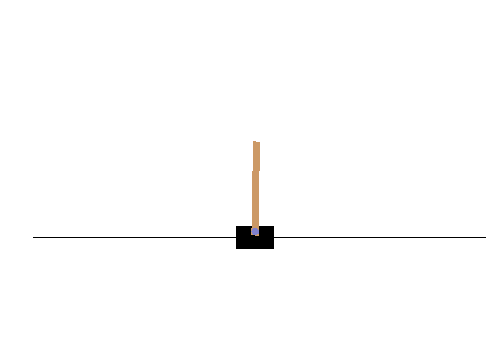

In [8]:
#set the environmnet
env = gym.make('CartPole-v1')

#instantiate the agent
agent = Agent(state_size=n_state[0], n_actions=n_actions)
env.seed(0)
frames = []
for i in range(1):
    initial_state = env.reset()
    state = initial_state
    score = 0
    while True:
        frames.append(env.render(mode = 'rgb_array'))
        action = agent.take_action(state)
        state, reward, done, _ = env.step(action)
        score += reward
        if done:
            break
    print('episode:', i, 'total score:', score)
env.render()

plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
patch = plt.imshow(frames[0])
plt.axis('off')
animate = lambda i: patch.set_data(frames[i])
anim = matplotlib.animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval = 50)
HTML(anim.to_jshtml())

From the above animation, before training the agent's q-network, the episode ended quickly with a total score of 9. The episode terminated because the pole immediately got inclined at angle greater than 15 degrees with the vertical.

**Train and see the agent achieve total rewards greater than 200 and have an episode that lasts longer.**

In [10]:
# We don't want too much logs
logging.getLogger().setLevel(logging.INFO)

#instantiate the agent
agent = Agent(state_size=n_state[0], n_actions=n_actions)


n_episodes=2000
epsilon_start=1.0
epsilon_end=0.01
epsilon_decay=0.995

scores = []                        # list containing scores from each episode
scores_window = deque(maxlen=100)  # last 100 scores
epsilon = epsilon_start                    # initialize epsilon

for episode in range(1, n_episodes+1):
    state = env.reset()
    score = 0
    while True:
        action = agent.take_action(state, epsilon)
        next_state, reward, done, _ = env.step(action)
        agent.step(state, action, reward, next_state, done)
        state = next_state
        score += reward
        if done:
            break 
    scores_window.append(score)       # save most recent score
    scores.append(score)              # save most recent score
    epsilon = max(epsilon_end, epsilon_decay*epsilon) # decrease epsilon
    
    print('\rEpisode {}\tLast 100 episodes Average Score: {:.2f}'.format(episode, np.mean(scores_window)), end="")
    if episode % 100 == 0:
        print('\rEpisode {}\tLast 100 episodes Average Score: {:.2f}'.format(episode, np.mean(scores_window)))
        
    # Enviroment is considered to be solved if last 100 episodes average score is greater than 200.
    if np.mean(scores_window)>=195.0:
        print('\n\nEnvironment solved in {:d} episodes!\nAverage Score: {:.2f}'.format(episode, np.mean(scores_window)))
        agent.qn_behaviour.save_weights('qn_behaviour.h5')
        break

Episode 100	Last 100 episodes Average Score: 30.91
Episode 200	Last 100 episodes Average Score: 144.02
Episode 300	Last 100 episodes Average Score: 188.31
Episode 342	Last 100 episodes Average Score: 195.07

Environment solved in 342 episodes!
Average Score: 195.07


## Observe Performance

plot the scores obtained for each episode. The agent achieved lower scores at the begining because of exploration. After a few runs, it starts exploiting it's knowlege of the action values to get more rewards.

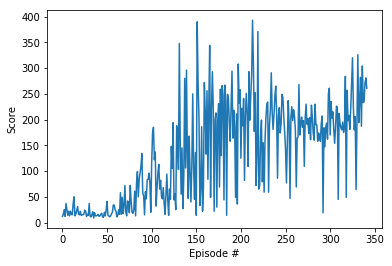

In [11]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

I0510 19:54:54.767447 140553169823616 animation.py:1146] Animation.save using <class 'matplotlib.animation.HTMLWriter'>


Test episode: 0 Score: 169.0


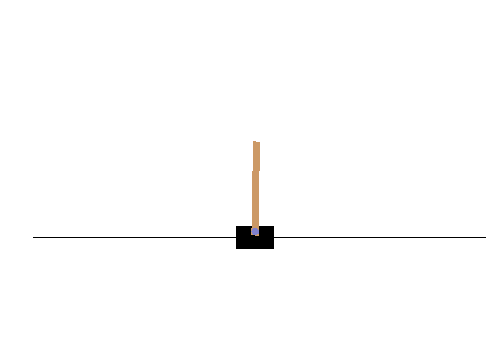

In [12]:

#set the environmnet
env = gym.make('CartPole-v1')

env.seed(0)
frames = []
for i in range(1):
    initial_state = env.reset()
    state = initial_state
    score = 0
    while True:
        frames.append(env.render(mode = 'rgb_array'))
        action = agent.take_action(state)
        state, reward, done, _ = env.step(action)
        score += reward
        if done: 
            break
    print('Test episode:', i, 'Score:', score)
env.render()

plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
patch = plt.imshow(frames[0])
plt.axis('off')
animate = lambda i: patch.set_data(frames[i])
anim = matplotlib.animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval = 50)
HTML(anim.to_jshtml())

From observations, after training the agents's q-network, the agent now achieves a very high total reward and the episode lasts longer. The episode ended as a result of the cart moving more than 2.4 units away from the center.

# ===============================================================